In [1]:
import pandas as pd
import numpy as np 


In [2]:
#Load Dataset

In [3]:
data = pd.read_csv(r"C:\Users\fastf\Downloads\Water quality dataset\grey_water_management.csv")

In [4]:
data.head()

,TDS (mg/l),Turbidity (NTU),pH,Depth (m),Flow Discharge (L/min),Filter Life Span (hours),Filter Efficiency (%)
0,187.270,4.487,6.459,1.903,21.447,4394.721,90.079
1,475.357,8.630,8.446,4.731,9.709,3982.861,87.321
2,365.997,8.695,6.364,0.974,37.508,4146.319,88.696
3,299.329,4.707,7.632,1.951,18.038,4446.934,90.701
4,78.009,9.729,6.033,3.438,50.817,3932.351,86.734


In [5]:
data.columns

Index(['TDS (mg/l)', 'Turbidity (NTU)', 'pH', 'Depth (m)',
       'Flow Discharge (L/min)', 'Filter Life Span (hours)',
       'Filter Efficiency (%)'],
      dtype='object')

In [6]:
data.isnull().sum()

TDS (mg/l)                  0
Turbidity (NTU)             0
pH                          0
Depth (m)                   0
Flow Discharge (L/min)      0
Filter Life Span (hours)    0
Filter Efficiency (%)       0
dtype: int64

In [7]:
#Create Potability Column

In [8]:
np.random.seed(42)
data['Potability'] = (
    ((data['pH'] + np.random.normal(0, 0.2, len(data))).between(6.5, 8.5)) &
    ((data['TDS (mg/l)'] + np.random.normal(0, 20, len(data))) <= 500) &
    ((data['Turbidity (NTU)'] + np.random.normal(0, 0.5, len(data))) <= 5)
).astype(int)


In [9]:
print(data['Potability'].value_counts())

Potability
0    12225
1     7431
Name: count, dtype: int64


In [10]:
data_clean = data.drop(columns=["Filter Life Span (hours)", "Filter Efficiency (%)"])


In [11]:
#Feature Selection

In [12]:
X = data_clean.drop("Potability", axis=1)
y = data_clean["Potability"]


In [13]:
# Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
# SMOTE Oversampling 

In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


In [17]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [18]:
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Potability
0    9780
1    5944
Name: count, dtype: int64
After SMOTE: Potability
0    9780
1    9780
Name: count, dtype: int64


In [19]:
# Feature Distribution

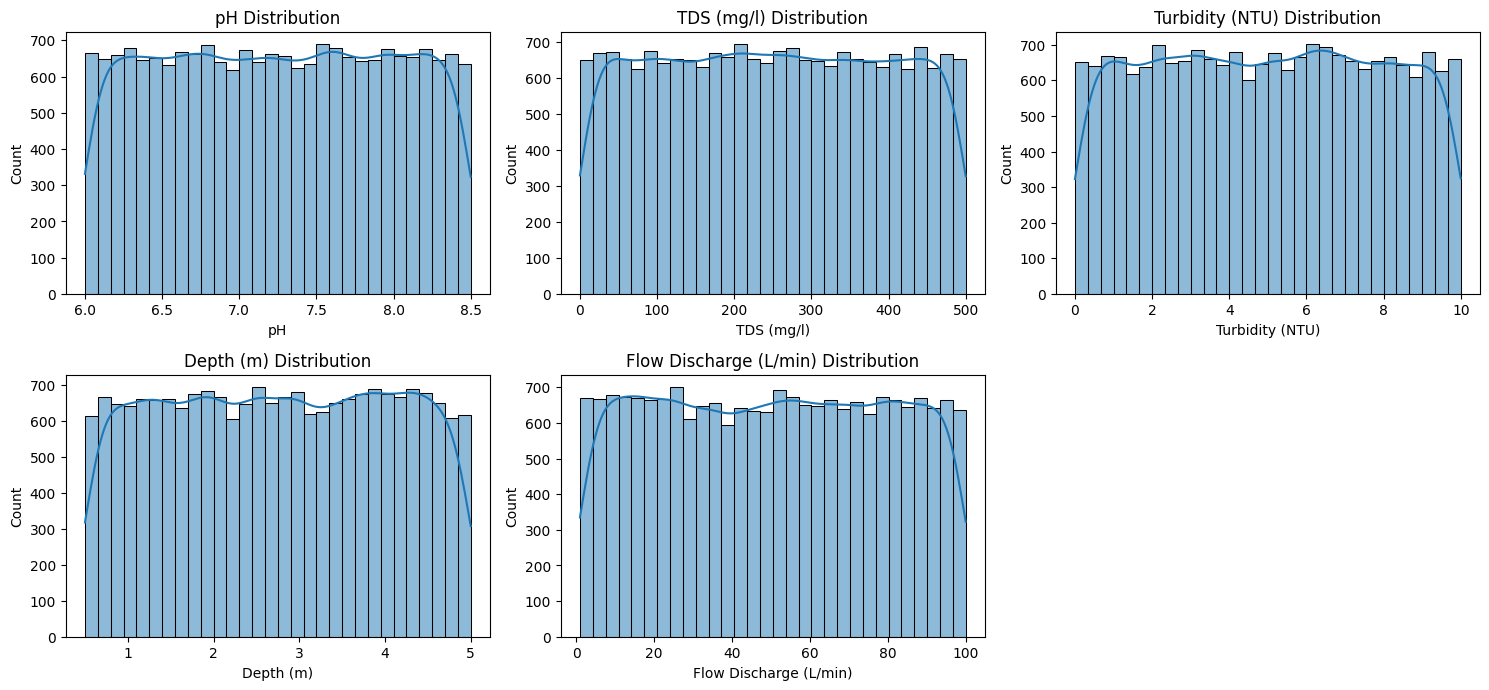

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
features = ['pH', 'TDS (mg/l)', 'Turbidity (NTU)', 'Depth (m)',
            'Flow Discharge (L/min)']

plt.figure(figsize=(15,10))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f"{col} Distribution")
plt.tight_layout()
plt.show()

In [21]:
# Correlation Heatmap

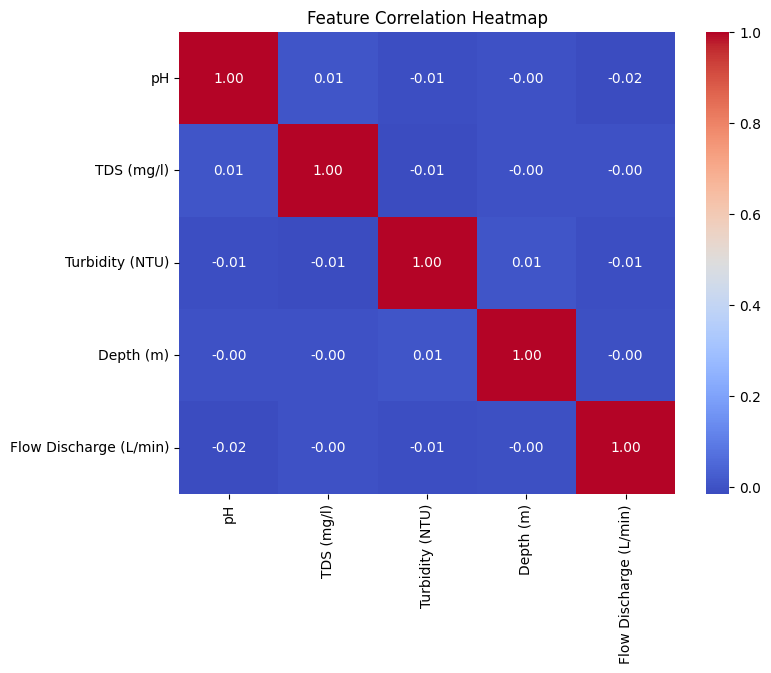

In [22]:
plt.figure(figsize=(8,6))
sns.heatmap(data[features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [23]:
#Feature Scaling

In [24]:
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [26]:
# Logistic Regression

In [27]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_res, y_train_res)

y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88      2445
           1       0.77      0.87      0.82      1487

    accuracy                           0.85      3932
   macro avg       0.84      0.86      0.85      3932
weighted avg       0.86      0.85      0.85      3932



In [28]:
# Random Forest

In [29]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2445
           1       0.87      0.91      0.89      1487

    accuracy                           0.91      3932
   macro avg       0.91      0.91      0.91      3932
weighted avg       0.91      0.91      0.91      3932



In [33]:
# Feature Importance

In [34]:
importances = rf.feature_importances_
for f, imp in zip(X.columns, importances):
    print(f"{f}: {imp:.4f}")



TDS (mg/l): 0.0458
Turbidity (NTU): 0.6584
pH: 0.2156
Depth (m): 0.0402
Flow Discharge (L/min): 0.0399


In [38]:
# Feature Importance Bar Plot

C:\Users\fastf\AppData\Local\Temp\ipykernel_15120\220859987.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')


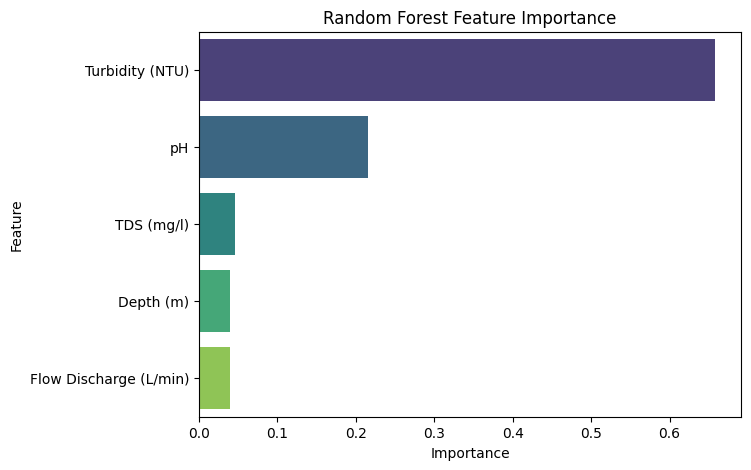

In [39]:
importances = rf.feature_importances_
features = X.columns  
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(7,5))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [40]:
# Safe Vs Unsafe Water Histogram

Text(0.5, 1.0, 'Turbidity Distribution: Safe vs Unsafe')

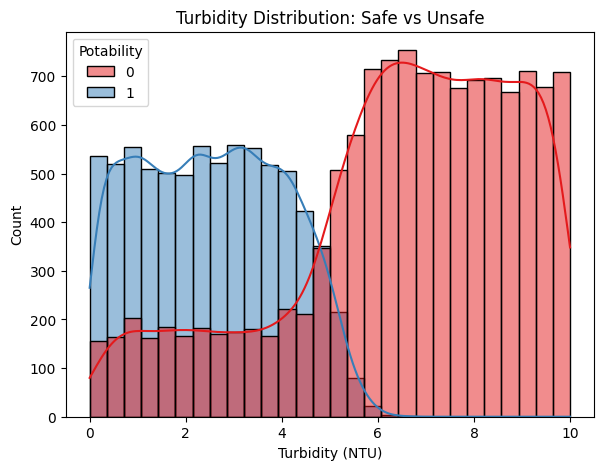

In [41]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(data, x='Turbidity (NTU)', hue='Potability', kde=True, palette='Set1', alpha=0.5)
plt.title("Turbidity Distribution: Safe vs Unsafe")



In [42]:
# Save The Final Model

In [44]:
import joblib
joblib.dump(rf, "final_water_quality_rf_model.pkl")


['final_water_quality_rf_model.pkl']

In [45]:
import joblib
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [65]:
# Prediction On New Data

In [66]:
rf_model = joblib.load("final_water_quality_rf_model.pkl")
scaler = joblib.load("scaler.pkl")
feature_order = ['pH', 'TDS (mg/l)', 'Turbidity (NTU)', 'Depth (m)', 'Flow Discharge (L/min)']

def predict_water_combined(sample):
    
    if 6.5 <= sample['pH'] <= 8.5 and sample['TDS (mg/l)'] <= 500 and sample['Turbidity (NTU)'] <= 5:
        return "Safe"
    
    
    sample_array = np.array([sample[feat] for feat in feature_order]).reshape(1, -1)
    sample_scaled = scaler.transform(sample_array)
    pred = rf_model.predict(sample_scaled)[0]
    return "Safe" if pred == 1 else "Unsafe"


sample1 = {'pH': 7.2, 'TDS (mg/l)': 400, 'Turbidity (NTU)': 3, 'Depth (m)': 2, 'Flow Discharge (L/min)': 10}
sample2 = {'pH': 6.0, 'TDS (mg/l)': 600, 'Turbidity (NTU)': 8, 'Depth (m)': 3, 'Flow Discharge (L/min)': 30}

print("Sample 1:", predict_water_combined(sample1))  
print("Sample 2:", predict_water_combined(sample2))  


Sample 1: Safe
Sample 2: Unsafe


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [70]:
import os
folder = r"C:\Users\fastf\Desktop\Water classification Model"
os.makedirs(folder, exist_ok=True)
import joblib
joblib.dump(rf_model, os.path.join(folder, "final_water_quality_rf_model.pkl"))
joblib.dump(scaler, os.path.join(folder, "scaler.pkl"))

print("Model and scaler saved successfully in the 'models' folder!")



Model and scaler saved successfully in the 'models' folder!
